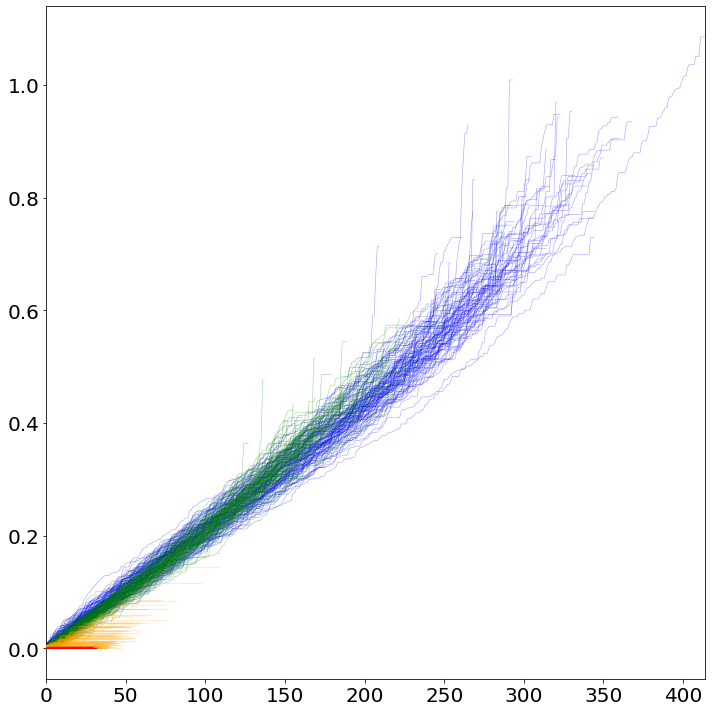

In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

base_dir = Path("data_rc_cycle/1.0_0.01/")  # adjust if needed
L = 30                             # your length (set accordingly)

color_map = {0.5: "red", 1.0: "orange", 1.5: "green", 2.0: "blue"}

files = sorted(base_dir.rglob("summary.npz"))

fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

for f in files:
    d = np.load(f, allow_pickle=False)
    w = float(d["width"]) if "width" in d else float(f.parent.name)
    y_all = np.asarray(d["volts_ext"], dtype=float)
    y = y_all[np.isfinite(y_all)]                 # drop NaNs, do not mutate original
    if y.size == 0:
        continue
    v_min = 1.0 - w / 2.0                         # nominal min strength for this width
    y_kahng = y / L - v_min                       # (V_ext / L) - v_min
    if w == 0.5:
        zorder=10000
    if w == 1.0:
        zorder=1000
    if w == 1.5:
        zorder=100
    if w == 2.0:
        zorder=10
    ax.plot(np.arange(y_kahng.size), y_kahng, lw=0.6, alpha=0.35, c=color_map.get(w, "gray"), zorder=zorder)

ax.margins(x=0)
ax.tick_params(labelsize=20)
plt.tight_layout()
plt.show()


In [13]:
from pathlib import Path
import numpy as np

# folder layout: data_rc_cycle/<val_cap>_<time_step>/<length>/<width>/<seed>/summary.npz
base_dir   = Path("data_rc_cycle/")
val_cap    = 1.0
time_step  = 0.01
length     = 30
widths     = [0.5, 1.0, 1.5, 2.0]

median_seed_by_width = {}

for w in widths:
    dir_w = base_dir / f"{val_cap}_{time_step}" / str(length) / str(w)
    files = sorted(dir_w.rglob("summary.npz"))
    if not files:
        median_seed_by_width[w] = None
        continue

    seeds, metrics = [], []
    for f in files:
        d = np.load(f, allow_pickle=False)
        y = np.asarray(d["volts_ext"], dtype=float)
        y = y[np.isfinite(y)]  # drop NaNs (don’t mutate)
        if y.size == 0:
            continue
        seeds.append(int(d["seed"]) if "seed" in d else int(f.parent.name))
        metrics.append(float(np.median(y)))  # per-run median volts_ext

    if not metrics:
        median_seed_by_width[w] = None
        continue

    seeds   = np.asarray(seeds)
    metrics = np.asarray(metrics)
    order   = np.argsort(metrics)
    rank    = (metrics.size - 1) // 2        # lower median: 49 for N=100
    median_seed_by_width[w] = int(seeds[order][rank])

print(median_seed_by_width)


{0.5: 3, 1.0: 71, 1.5: 17, 2.0: 30}


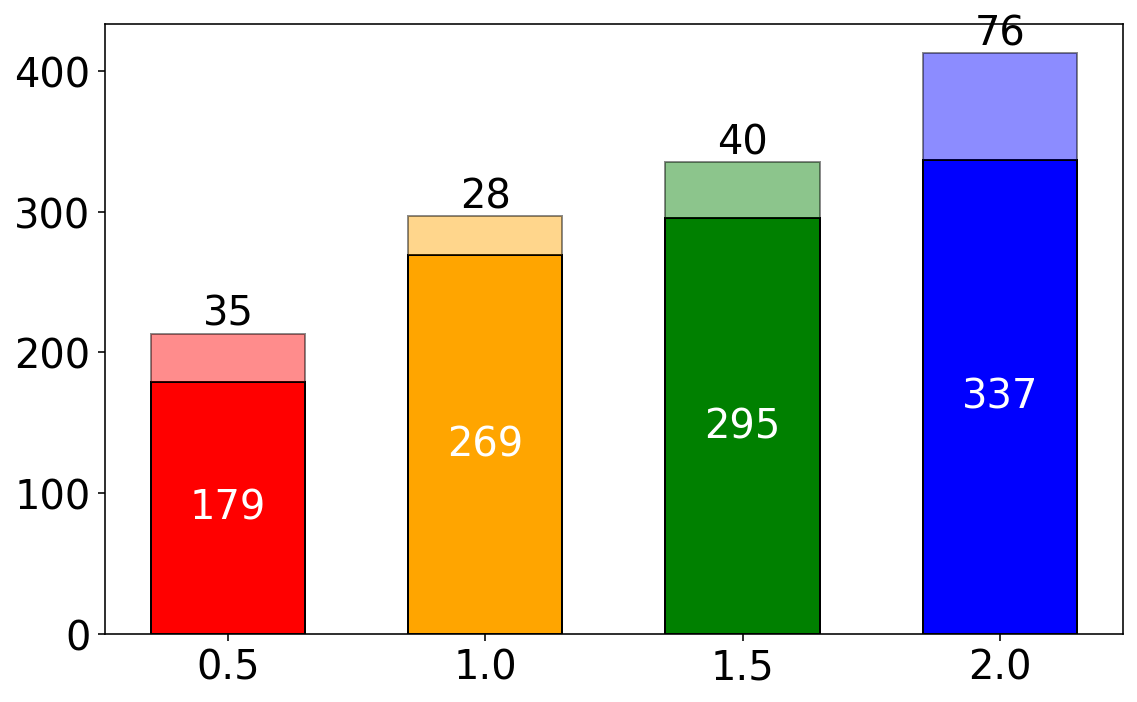

In [20]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

base = Path("data_rc_cycle") / "0.01_0.01" / "30"   # <- specific to 0.01_0.01
widths = [0.5, 1.0, 1.5, 2.0]
colors = {0.5: "red", 1.0: "orange", 1.5: "green", 2.0: "blue"}

avg_ch, avg_dch = [], []

for w in widths:
    files = sorted((base / str(w)).glob("*/summary.npz"))
    ch_vals, dch_vals = [], []
    for f in files:
        d = np.load(f, allow_pickle=False)
        ch_vals.append(int(d["num_broken_charge"]))
        dch_vals.append(int(d["num_broken_discharge"]))
    if ch_vals:
        avg_ch.append(float(np.mean(ch_vals)))
        avg_dch.append(float(np.mean(dch_vals)))
    else:
        avg_ch.append(0.0)
        avg_dch.append(0.0)

x = np.arange(len(widths), dtype=float)
barw = 0.6

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=144)

for i, w in enumerate(widths):
    c = colors[w]
    # bottom: charge
    b1 = ax.bar(x[i], avg_ch[i], width=barw, color=c, edgecolor="black")
    # top: discharge
    b2 = ax.bar(x[i], avg_dch[i], width=barw, bottom=avg_ch[i], color=c, alpha=0.45, edgecolor="black")
    # numbers (rounded to int)
    ch_int  = int(round(avg_ch[i]))
    dch_int = int(round(avg_dch[i]))
    # place charge number inside bottom segment (if tall enough)
    if avg_ch[i] > 0.6:
        ax.text(x[i], avg_ch[i]*0.5, f"{ch_int}", ha="center", va="center", fontsize=20, color="white")
    else:
        ax.text(x[i], avg_ch[i] + 0.05, f"{ch_int}", ha="center", va="bottom", fontsize=20, color="black")
    # place discharge number above the stack
    ax.text(x[i], avg_ch[i] + avg_dch[i] + 0.05, f"{dch_int}", ha="center", va="bottom", fontsize=20, color="black")

ax.set_xticks(x, [str(w) for w in widths])
# ax.set_xlabel("width")
# ax.set_ylabel("avg # broken bonds (charge + discharge)")
ax.tick_params(labelsize=20)
ax.margins(x=0.05)
plt.tight_layout()
plt.show()


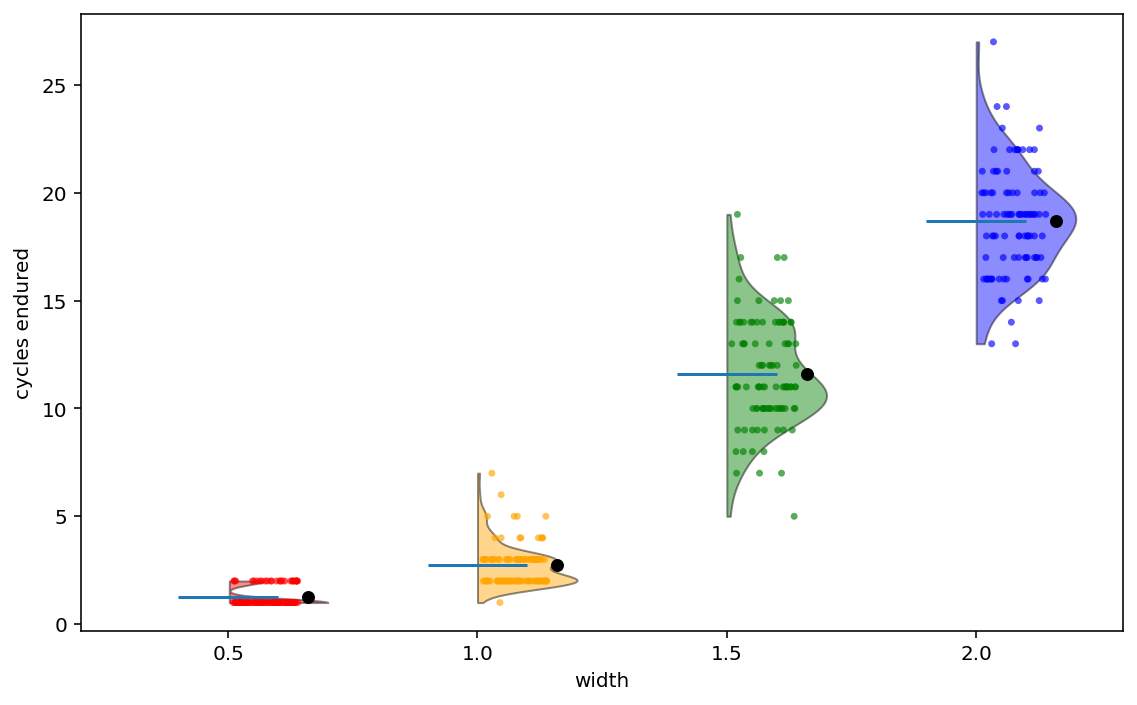

In [22]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# data root specific to 0.01_0.01 / 30
base = Path("data_rc_cycle") / "1.0_0.01" / "30"
widths = [0.5, 1.0, 1.5, 2.0]
colors = ["red", "orange", "green", "blue"]

# load cycles per width
data = []
for w in widths:
    files = sorted((base / str(w)).glob("*/summary.npz"))
    cycles = []
    for f in files:
        d = np.load(f, allow_pickle=False)
        cycles.append(int(d["cycles_endured"]))
    data.append(np.asarray(cycles, dtype=int))

x = np.arange(len(widths), dtype=float)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=144)

# full violins, then clip to half
parts = ax.violinplot(
    data,
    positions=x,
    widths=0.8,
    showmeans=True,   # Matplotlib draws a mean line; we'll also add a dot
    showmedians=False,
    showextrema=False
)

# color & convert to half (keep right half)
for pc, c in zip(parts["bodies"], colors):
    pc.set_facecolor(c)
    pc.set_edgecolor("black")
    pc.set_alpha(0.45)
    verts = pc.get_paths()[0].vertices
    xmid = np.mean(verts[:, 0])
    verts[verts[:, 0] < xmid, 0] = xmid  # collapse left half onto center

# scatter: each seed as a point with small right-side jitter
rng = np.random.default_rng(0)
for xi, cycles, c in zip(x, data, colors):
    if cycles.size == 0:
        continue
    jitter = rng.uniform(0.02, 0.28, size=cycles.size)  # keep on the shown (right) half
    ax.scatter(np.full_like(cycles, xi) + jitter, cycles, s=12, color=c, edgecolors="none", alpha=0.65, zorder=3)

# mean markers
means = [np.mean(v) if v.size else np.nan for v in data]
ax.scatter(x + 0.32, means, s=30, color="black", zorder=4)

ax.set_xticks(x, [str(w) for w in widths])
ax.set_xlabel("width")
ax.set_ylabel("cycles endured")
ax.margins(x=0.05)
plt.tight_layout()
plt.show()
